In [3]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import zipfile
import urllib.request
import os
import matplotlib.pyplot as plt
import shutil
from PIL import Image, ImageDraw
import random
import re

In [13]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };

    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }

        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

# Création Metadata DataFrame
Etape intermédiaire: dézipper le csv fourni

In [5]:
all_df = pd.read_csv("data/202001-rma-csv-collection.csv")

all_df = all_df.rename(columns =
                       {"objectInventoryNumber":"inventoryNumber","objectPersistentIdentifier":"identifier",
                        "objectTitle[1]":"title","objectType[1]":"type","objectCreator[1]":"creator",
                        "objectCreationDate[1]":"creationDate","objectImage":"imageUrl"})

art_types = list(all_df["type"].drop_duplicates())

paintings_df = all_df[all_df.type == "schilderij"]

# Get images from the web

Peut prendre du temps. On peut voir la progression en checkant le nombre d'images dans le dossier rijk_images

In [6]:
def get_image(persistentID, url, path):
    if not os.path.exists(path):
                urllib.request.urlretrieve(url,path)

In [8]:
paintings_images_df = paintings_df[["identifier","imageUrl"]].dropna()

paintings_images_df.apply(lambda row: get_image(row.identifier, row.imageUrl,"data/images_rijk/{}.jpg"\
                             .format(row.identifier.split(".")[-1])), axis = 1)

paintings_images_df["image_identifier"] = paintings_images_df.identifier.apply(lambda i : int(i.split(".")[-1]))

In [9]:
full_paintings_df = paintings_df.join(paintings_images_df["image_identifier"], how = "inner")

# Préparation pour choix avant détection de pose

In [10]:
def decide_picture_before(identifier):
        
    path = "data/images_rijk/{}.jpg".format(identifier)
    
    im = Image.open(path)
    
    plt.figure(figsize = (5,5))
    plt.imshow(np.asarray(im))
    plt.show()
    
    answer = input("Keep ? (y/n)")
    
    plt.clf()
    
    if answer in ["yes","y","oui","1"]:
        shutil.copyfile(path, "data/images_rijk_selected_before/{}.jpg".format(identifier))
        return 1
    
    if answer ==  "break":
        return "break"
    
    else:
        return 0

In [11]:
# Préparation et sauvegarde du dataFrame sans les indications de sélection
full_paintings_df["selected_before"] = np.nan
full_paintings_df["selected_after"] = np.nan
full_paintings_df.to_csv("data/raw_full_paintings_df.csv")

Etape intermédiaire: renommer raw_full_paintings_df.csv en partial_selected_full_paintings_df.csv ou réutiliser le csv déjà fourni

# Choix avant 

Fonctionnement:
- Avant les choix, le csv partial_selected_full_paintings_df.csv est chargé
- Durant le choix, si y, selected_before est mis à 1 dans la row de l'image, sinon mis à 0
- Si y, l'image est copiée dans un nouveau dossier image_rijk_selected_before.
- Pour interrompre la boucle de choix sans générer d'exception, taper "break"
- Après avoir interrompu la boucle, exécuter la deuxième cellule pour sauvegarder partial_selected_full_paintings_df.csv
- Reéxécuter la première cellule pour reprendre le choix là où on l'a laissé.

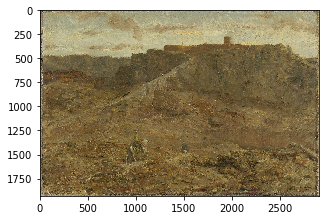

Keep ? (y/n)break


<Figure size 432x288 with 0 Axes>

In [17]:
full_paintings_df = pd.read_csv("data/partial_selected_full_paintings_df.csv")

for i, row in full_paintings_df.iterrows():
    if (row["selected_before"] != 0 and row["selected_before"] != 1):
        
        answer = decide_picture_before(row["image_identifier"])
        
        if answer == "break":
            break
        else:
            full_paintings_df.at[i,'selected_before'] = answer

#sauvegarde de sécurité du dataFrame à la fin de la session de choix
full_paintings_df.to_csv("data/temp/temp_{}.csv".format(random.randint(0,1e10)))


In [18]:
#Sauvegarde de l'état actuel
full_paintings_df.to_csv("data/partial_selected_full_paintings_df.csv")

# Préparation choix après

Etape intermédiaire: appliquer avec runwayML l'algo de détection de pose aux images de rijk_selected_images. Séparer en batches d'une huitantaine d'images s'il y en a trop dans le dossier.

Grouper les résultats dans un fichier dont on spécifie le nom et la localisation juste en dessous.

In [ ]:
JSON_NAME = "data/rijk.json"

In [ ]:
def parse_posenet_json(df, json_name, normalise_function = lambda x: x):
    
    with open(json_name,"r") as json:
        
        text = json.read()
        
        dics = []
        
        for item in eval(text):
            image_name = item.get("filename")
            
            image_id = int(re.match("\d+",image_name).group())
            
            poses = item.get("poses")
            
            normalized_poses = list(map(normalise_function, poses))
            
            dics.append({"image_identifier":image_id, "poses":poses, "norm_poses":normalized_poses})
    
    
    return df.merge(pd.DataFrame(dics), on = "image_identifier")

In [ ]:
def decide_picture_after(poses, identifier):
    
    path = "data/images_rijk_selected_before/{}.jpg".format(identifier)
    
    im = Image.open(path)
    
    c = 0
    colors = ["red","yellow","green","blue","grey"]
    for pose in poses:
        
        color = colors[c]
        
        width, height = im.size

        draw = ImageDraw.Draw(im)
        
        pose = list(map(lambda tup : (width*tup[0], height*tup[1]), pose))
        
        for point in pose[:5]:
            x = point[0]
            y = point[1]
            r = 5
            draw.ellipse([x-r,y-r,x+r,y+r],color,color)

        for i in (5,6,11,12):
            draw.line([(pose[i][0],pose[i][1]),(pose[i+2][0],pose[i+2][1]),(pose[i+4][0],pose[i+4][1])],
                      fill = color, width = 5)
        
        c += 1
        
    plt.figure(figsize = (10,10))
    plt.imshow(np.asarray(im))
    plt.show()
    
    answer = input("Keep ? (y/n)")
    
    plt.clf()
    
    if answer in ["y","yes","oui",1]:
        shutil.copyfile(path, "data/images_rijk_selected_after/{}.jpg".format(identifier))
        return 1
    
    if answer ==  "break":
        return "break"

    return 0

In [ ]:
poses_paintings_df = parse_posenet_json(full_paintings_df, JSON_NAME)

In [ ]:
poses_paintings_df.to_csv("data/final_selected_full_paintings_df.csv")

# Choix après

Fonctionnement:
- Avant les choix, le csv final_selected_full_paintings_df.csv est chargé
- Durant le choix, si y, selected_after est mis à 1 dans la row de l'image, sinon mis à 0
- Si y, l'image est copiée dans un nouveau dossier image_rijk_selected_after.
- Pour interrompre la boucle de choix sans générer d'exception, taper "break"
- Après avoir interrompu la boucle, exécuter la deuxième cellule pour sauvegarder final_selected_full_paintings_df.csv
- Reéxécuter la première cellule pour reprendre le choix là où on l'a laissé.

In [ ]:
poses_paintings_df = pd.read_csv("data/final_selected_full_paintings_df.csv")

for i, row in poses_paintings_df.iterrows():
    if (row["selected_before"] == 1 and row["selected_after"] != 0 and row["selected_after"] != 1):
        
        answer = decide_picture_after(eval(row["poses"]),row["image_identifier"])
        
        if answer == "break":
            break
        else:
            full_paintings_df.set_value(i,'selected_after',answer)

#sauvegarde de sécurité du dataFrame à la fin de la session de choix
poses_paintings_df.to_csv("data/temp/temp_{}.csv".format(random.randint(0,1e10)))

In [ ]:
#Sauvegarde de l'état actuel
poses_paintings_df.to_csv("data/final_selected_full_paintings_df.csv")